In [1]:
from dash import Dash, html, dcc, callback, Output, Input, dash_table
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pickle
import re
import numpy as np
import pandas as pd

with open('evaluation_full.pkl', 'rb') as f:
    df = pickle.load(f)
    
with open('evaluation_roc.pkl', 'rb') as f:
    df_roc = pickle.load(f)

/var/folders/92/j78p1t2n7xxf3nf7zgdc3t4w0000gn/T/ipykernel_1383/542821723.py:17: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  integral = trapz(group_data['Accuracy'], group_data['Coverage'])


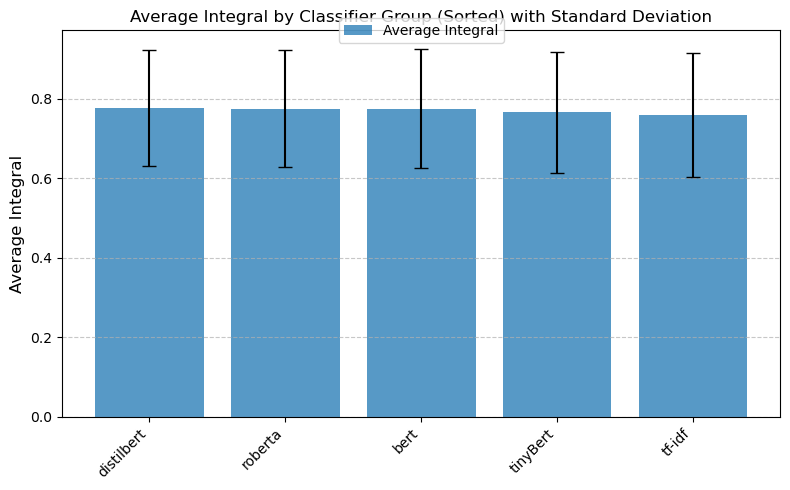

In [5]:
from scipy.integrate import trapz
import matplotlib.pyplot as plt
import numpy as np

temp = df[df['Dataset'].str.contains('Base_Phi', na=False)]
temp2 = temp[~temp['Dataset'].str.contains('Interpolated', na=False)]

grouped = temp2.groupby(['Dataset', 'Data_size', 'Method_Classifier'])

# Compute the integral for each group
results = []
for group_name, group_data in grouped:
    # Sort by Coverage to ensure proper integration
    group_data = group_data.sort_values('Coverage')
    
    # Compute the integral using trapezoidal rule
    integral = trapz(group_data['Accuracy'], group_data['Coverage'])
    
    # Append the result
    results.append({
        'Dataset': group_name[0],
        'Data_size': group_name[1],
        'Method_Classifier': group_name[2],
        'Integral': integral
    })

# Convert results to DataFrame
integral_df = pd.DataFrame(results)

max_data_size = integral_df.groupby('Dataset')['Data_size'].max().reset_index()
max_data_size.rename(columns={'Data_size': 'Max_Data_size'}, inplace=True)

# Merge with the original DataFrame to filter rows with maximum Data_size
res = pd.merge(integral_df, max_data_size, left_on=['Dataset', 'Data_size'], right_on=['Dataset', 'Max_Data_size'])

# Drop the extra column if you don't need it
res = res.drop(columns=['Max_Data_size'])

groups = {
    'tf-idf': ['Tf-Idf Embedding Random Forest', 'Tf-Idf Embedding SVM', 'Tf-Idf Embedding Simple NN', 
               'Tf-Idf Embedding Logistic Regression', 'Tf-Idf Outlier generic'],
    'tinyBert': ['TinyBert Embedding Random Forest', 'TinyBert Embedding SVM', 'TinyBert Embedding Simple NN',
                'TinyBert Embedding Logistic Regression', 'TinyBert Outlier generic'],
    'bert': ['Bert Embedding Random Forest', 'Bert Embedding SVM', 'Bert Embedding Simple NN',
                'Bert Embedding Logistic Regression', 'Bert Outlier generic'],
    'roberta': ['RoBERTa Embedding Random Forest', 'RoBERTa Embedding SVM', 'RoBERTa Embedding Simple NN',
                'RoBERTa Embedding Logistic Regression', 'RoBERTa Outlier generic'],
    'distilbert': ['Distilbert Embedding Random Forest', 'Distilbert Embedding SVM', 'Distilbert Embedding Simple NN',
                'Distilbert Embedding Logistic Regression', 'Distilbert Outlier generic']
}

def classify(method):
    for group, classifiers in groups.items():
        if method in classifiers:
            return group
    return 'other' 

res['Classifier_Group'] = res['Method_Classifier'].apply(classify)

result = res.groupby('Classifier_Group')['Integral'].agg(['mean', 'std']).reset_index()
result = result[result['Classifier_Group'] != 'other']

width = 0.8

df_sorted = result.sort_values(by="mean", ascending=False)

x = np.arange(len(df_sorted)) 

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x, df_sorted["mean"], yerr=df_sorted["std"], capsize=5, alpha=0.75, width=width, label="Average Integral")

ax.set_ylabel('Average Integral', fontsize=12)
#ax.set_xlabel('Classifier Group')
ax.set_title('Average Integral by Classifier Group (Sorted) with Standard Deviation')
ax.set_xticks(x)
ax.set_xticklabels(df_sorted["Classifier_Group"], rotation=45, ha='right')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [2]:
groups = {
    'TF-IDF': ['Tf-Idf Embedding Random Forest', 'Tf-Idf Embedding SVM', 'Tf-Idf Embedding Simple NN', 
               'Tf-Idf Embedding Logistic Regression', 'Tf-Idf Outlier generic'],
    'TBert': ['TinyBert Embedding Random Forest', 'TinyBert Embedding SVM', 'TinyBert Embedding Simple NN',
                'TinyBert Embedding Logistic Regression', 'TinyBert Outlier generic'],
    'Bert': ['Bert Embedding Random Forest', 'Bert Embedding SVM', 'Bert Embedding Simple NN',
                'Bert Embedding Logistic Regression', 'Bert Outlier generic'],
    'RBert': ['RoBERTa Embedding Random Forest', 'RoBERTa Embedding SVM', 'RoBERTa Embedding Simple NN',
                'RoBERTa Embedding Logistic Regression', 'RoBERTa Outlier generic'],
    'DBert': ['Distilbert Embedding Random Forest', 'Distilbert Embedding SVM', 'Distilbert Embedding Simple NN',
                'Distilbert Embedding Logistic Regression', 'Distilbert Outlier generic']
}

def classify(method):
    for group, classifiers in groups.items():
        if method in classifiers:
            return group
    return 'other' 

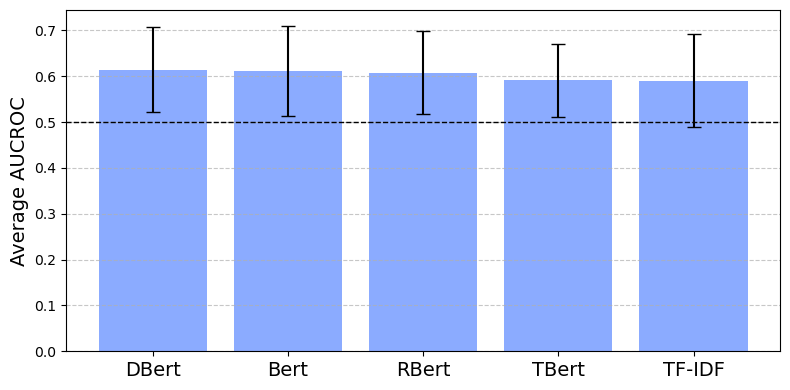

In [5]:
temp = df[df['Dataset'].str.contains('Base_Phi', na=False)]
temp = temp[~temp['Dataset'].str.contains('Interpolated', na=False)]

max_data_size = temp.groupby('Dataset')['Data_size'].max().reset_index()

temp_array = []
for _, row in max_data_size.iterrows():
    dataset = row['Dataset']
    size = row['Data_size']
    for group in groups.keys():
        models = groups[group]
        for model in models:
            roc = df_roc[dataset][size][model]['roc_auc']
            temp_array.append([group, roc])

temp_df = pd.DataFrame(temp_array, columns=['method', 'roc'])

stats_df = temp_df.groupby("method")["roc"].agg(mean="mean", std="std").reset_index()
stats_df_sorted = stats_df.sort_values(by="mean", ascending=False)

x = np.arange(len(stats_df_sorted))  

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(
    x, stats_df_sorted["mean"], 
    yerr=stats_df_sorted["std"], 
    capsize=5, alpha=0.75, width=0.8, color="#648FFF", label="Average ROC"
)

ax.axhline(
    y=0.5,                 
    color='black',      
    linestyle='--',       
    linewidth=1 
)

ax.set_ylabel('Average AUCROC', fontsize=14)
#ax.set_xlabel('Rejector Model')
#ax.set_title('Average ROC by Method with Standard Deviation')
ax.set_xticks(x)
ax.set_xticklabels(stats_df_sorted["method"], rotation=0, ha='center', fontsize=14)

#ax.legend(loc='best')

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('exp1_embedding', dpi=300, bbox_inches='tight') 
plt.show()

In [60]:
stats_df_sorted['mean'] = stats_df_sorted['mean'].round(3)
stats_df_sorted['std'] = stats_df_sorted['std'].round(3)

In [65]:
stats_df_sorted

,method,mean,std
1,DBert,0.615,0.093
0,Bert,0.611,0.098
2,RBert,0.608,0.090
3,TBert,0.591,0.079
4,TF-IDF,0.590,0.102
